# We first import the modules we will need

In [88]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as c
import seaborn as sns

import pyproj    
import shapely
import shapely.ops as ops
from shapely.geometry.polygon import Polygon
from shapely.geometry.point import Point
from functools import partial

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error

from hyperopt import hp, tpe, fmin, Trials

print("Import succesful!")

Import succesful!


# Merging the area and rental price data

The data we will analyze comes from three different sources. First, we will have to merge all of these different sources together.

In [89]:
venue_df = pd.read_csv('Venues_Hamburg_Clean.csv')
area_df = pd.read_csv('Area_Postal_Codes_Hamburg.csv')
rental_prices_df = pd.read_csv('Rental_Prices_Postal_Codes_Hamburg.csv')

In [90]:
df = area_df.merge(rental_prices_df, on='Postal_Code')

# Exploring the venue data

To explore the data obtained from Foursquare, we will first look at only the main categories, i.e. 'Category_L1'. We use one hot encoding to make these entries numerical.

In [91]:
venue_df.drop(columns=['Category_L2', 'Category_L3', 'Category_L4', 'Venue_Id', 'Latitude', 'Longitude', 'Name'], inplace=True)

In [92]:
venue_df_one_hot = pd.get_dummies(venue_df, prefix='', prefix_sep='', columns=['Category_L1'])

We now define a new dataframe where the entries in the columns are given by the number of venues of the given category divided by the total number of venues. The rows are indexed by the postal code.

In [93]:
grouped_venue_df = venue_df_one_hot.groupby('Postal_Code').sum().div(venue_df.groupby('Postal_Code').size(), axis=0)
grouped_venue_df['Total Number of Venues'] = venue_df.groupby('Postal_Code').size()

It is clear that there are very few venues that fall in the 'College & University', 'Professional & Other Places' or 'Residence' categories. We are therefore simply going to drop these columns.

In [94]:
grouped_venue_df.drop(columns=['College & University', 'Professional & Other Places', 'Residence'], inplace=True)

Let us explore the occurence of the other categories in several histograms.

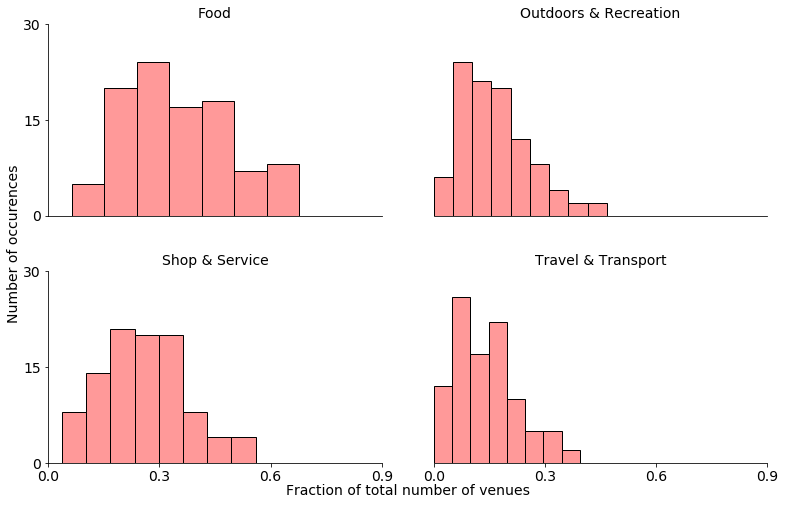

In [95]:
fig, axes = plt.subplots(2, 2, figsize=(12,8))

axes[0,0].hist(grouped_venue_df['Food'], bins='fd', color='#ff9999', edgecolor='black')
axes[0,1].hist(grouped_venue_df['Outdoors & Recreation'], bins='fd', color='#ff9999', edgecolor='black')
axes[1,0].hist(grouped_venue_df['Shop & Service'], bins='fd', color='#ff9999', edgecolor='black')
axes[1,1].hist(grouped_venue_df['Travel & Transport'], bins='fd', color='#ff9999', edgecolor='black')

axes[0,0].set_title("Food", size=14)
axes[0,1].set_title("Outdoors & Recreation", size=14)
axes[1,0].set_title("Shop & Service", size=14)
axes[1,1].set_title("Travel & Transport", size=14)

plt.setp(axes[1,:], xticks=[0.0, 0.3, 0.6, 0.9])
plt.setp(axes[0,:], xticks=[])
plt.setp(axes[:,0], yticks=[0, 15, 30])
plt.setp(axes[:,1], yticks=[])
plt.setp(axes, xlim=(0, 0.9), ylim=(0, 30))

for i in range(2):
    for j in range(2):
        axes[i,j].tick_params(labelsize=14)
    
for i in range(2):
    axes[i,0].spines['top'].set_visible(False)
    axes[i,0].spines['right'].set_visible(False)
    
    axes[i,1].spines['top'].set_visible(False)
    axes[i,1].spines['right'].set_visible(False)
    axes[i,1].spines['left'].set_visible(False)
        
fig.add_subplot(1, 1, 1, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel("Fraction of total number of venues", size=14)
plt.ylabel("Number of occurences", size=14)

plt.tight_layout(pad=3.0)
plt.show()

These histograms look somewhat similar to each other. There do not seem to be many outliers nor many postal codes where the fractions are precisely 0.0.

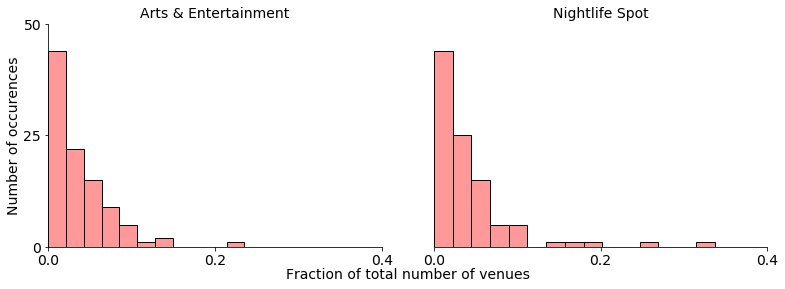

In [96]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

axes[0].hist(grouped_venue_df['Arts & Entertainment'], bins='fd', color='#ff9999', edgecolor='black')
axes[1].hist(grouped_venue_df['Nightlife Spot'], bins='fd', color='#ff9999', edgecolor='black')

axes[0].set_title("Arts & Entertainment", size=14)
axes[1].set_title("Nightlife Spot", size=14)

plt.setp(axes, xticks=[0.0, 0.2, 0.4], xlim=(0, 0.4), ylim=(0, 50))

axes[0].set_yticks([0, 25, 50])
axes[1].set_yticks([])

fig.add_subplot(1, 1, 1, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel("Fraction of total number of venues", size=14)
plt.ylabel("Number of occurences", size=14)

axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

axes[1].spines['left'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

for i in range(2):
    axes[i].tick_params(labelsize=14)

plt.tight_layout(pad=3.0)
plt.show()

There are many postal codes which contain very few or no venues of types 'Arts & Entertainment' or 'Nightlife Spot'. Nonetheless, there are some postal codes with many occurences of these types. Let us look at one of them.

In [97]:
max_fraction_nightlife = grouped_venue_df['Nightlife Spot'].max()

grouped_venue_df.loc[grouped_venue_df['Nightlife Spot'] == max_fraction_nightlife].index

Int64Index([20359], dtype='int64', name='Postal_Code')

The postal code 20359 belongs to St. Pauli, which is a district famous for its nightlife.

Based on these distributions, it might prove more difficult to use the 'Arts & Entertainment' and 'Nightlife Spot' categories to make predictions on the rental price.

# Merging all dataframes together

In [98]:
df = df.merge(grouped_venue_df, on='Postal_Code').set_index('Postal_Code')

In [99]:
df

,Area,Rental_Price,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service,Travel & Transport,Total Number of Venues
Postal_Code,,,,,,,,,
20095,0.759284,20.35,0.092593,0.481481,0.064815,0.055556,0.268519,0.037037,108
20097,1.968939,15.55,0.064516,0.435484,0.032258,0.032258,0.177419,0.258065,62
20099,1.589162,15.93,0.036496,0.591241,0.102190,0.058394,0.116788,0.094891,137
20144,0.931352,18.45,0.064516,0.387097,0.032258,0.258065,0.193548,0.064516,31
20146,0.940159,17.81,0.062500,0.675000,0.087500,0.000000,0.100000,0.062500,80
...,...,...,...,...,...,...,...,...,...
22761,3.720915,13.68,0.020619,0.412371,0.051546,0.113402,0.298969,0.082474,97
22763,2.529803,14.75,0.015152,0.439394,0.015152,0.212121,0.121212,0.151515,66
22765,2.193986,16.26,0.041916,0.580838,0.095808,0.077844,0.161677,0.035928,167


# Venue density as main driving factor for rental prices

Before we go into a more detailed analysis, let us look how the total number of venues and area relate to the rental price. If we expect a relationship between the number of venues and rental price, we would expect this relationship to be most clearly expressed by the amount of venues per area and the price.

In [100]:
df['Venue Density'] = df['Total Number of Venues'] / df['Area']

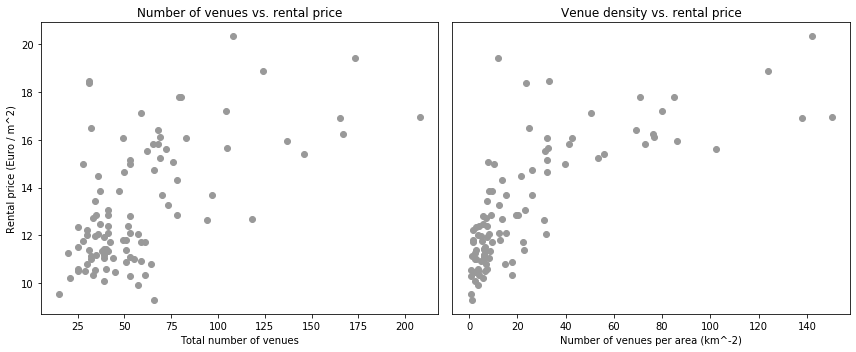

In [101]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

axes[0].scatter(df['Total Number of Venues'], df['Rental_Price'], color='#999999')
axes[0].set_title("Number of venues vs. rental price")
axes[0].set_xlabel("Total number of venues")
axes[0].set_ylabel("Rental price (Euro / m^2)")

axes[1].scatter(df['Venue Density'], df['Rental_Price'], color='#999999')
axes[1].set_title("Venue density vs. rental price")
axes[1].set_xlabel("Number of venues per area (km^-2)")
axes[1].set_yticks([])

plt.tight_layout()
plt.show()

In [102]:
print(
    "The Kendall correlation coefficient (tau) between the rental price and the total number of venues is given by: {:.3f}"\
    .format(df.corr(method='kendall')['Rental_Price']['Total Number of Venues'])
     )

print(
    "The Kendall correlation coefficient (tau) between the rental price and the venue density is given by: {:.3f}"\
    .format(df.corr(method='kendall')['Rental_Price']['Venue Density'])
     )

The Kendall correlation coefficient (tau) between the rental price and the total number of venues is given by: 0.365
The Kendall correlation coefficient (tau) between the rental price and the venue density is given by: 0.608


Although there seems to be a possibly linear relationship between the total number of venues and the rental price, we see a much tighter relationship between the venue density and the rental price, albeit nonlinear. Let us try to fit a polynomial to the second plot.

In [103]:
x = np.array(df['Venue Density']).reshape(-1,1)
y = df['Rental_Price']

poly_model = make_pipeline(PolynomialFeatures(3), LinearRegression())

x_fit = np.linspace(0, 170, 1000).reshape(-1,1)

poly_model.fit(x, y)
y_fit = poly_model.predict(x_fit)
y_pred = poly_model.predict(x)

print("The MAE of this model is {:3f} Euro / m^2".format(mean_absolute_error(y_pred, y)))
print("The R^2-score of this model is {:3f}".format(poly_model.score(x, y)))

The MAE of this model is 1.084853 Euro / m^2
The R^2-score of this model is 0.666401


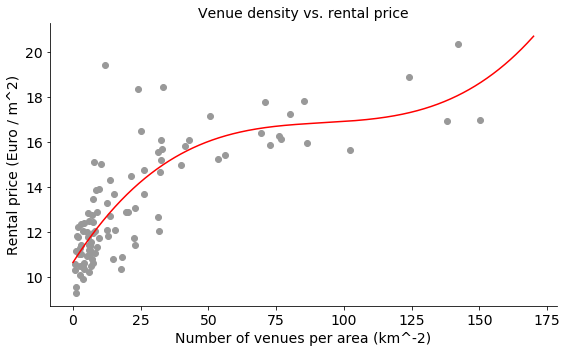

In [104]:
fig, ax = plt.subplots(figsize=(8,5))

ax.scatter(x, y, color='#999999')
ax.plot(x_fit, y_fit, color='#ff0000')

ax.set_xlabel("Number of venues per area (km^-2)", fontsize=14)
ax.set_ylabel("Rental price (Euro / m^2)", fontsize=14)
ax.set_title("Venue density vs. rental price", fontsize=14)

ax.tick_params(labelsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

If we look at other features, it is clear that the venue density correlates most strongly with the rental price. It should also be noted that the area and venue density are highly correlated with each other by the very definition of the venue density. We therefore do not get much new information out of the area feature.

In [105]:
df.corr(method='kendall')['Rental_Price']

Area                     -0.511652
Rental_Price              1.000000
Arts & Entertainment      0.211214
Food                      0.476240
Nightlife Spot            0.333766
Outdoors & Recreation    -0.232621
Shop & Service           -0.374368
Travel & Transport       -0.307581
Total Number of Venues    0.364647
Venue Density             0.608167
Name: Rental_Price, dtype: float64

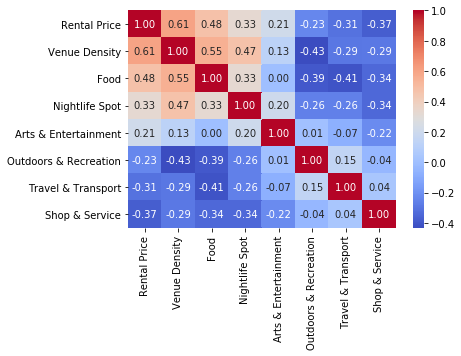

In [106]:
sorted_corr_df = df.rename(columns={'Rental_Price': 'Rental Price'})\
.drop(columns=['Area', 'Total Number of Venues']).corr(method='kendall')\
.sort_values(axis=0, by='Rental Price', ascending=False)\
.sort_values(axis=1, by='Rental Price', ascending=False)

sns.heatmap(
    sorted_corr_df, 
    cmap='coolwarm',
    annot=True,
    fmt='.2f'
)

plt.show()

# Using LASSO regularization to determine effects of lower significance

LASSO is a regularization technique that is performed by adding a term proportional to the L1-norm of the coefficients of a linear regression obtained by the ordinary least squares method. By increasing the regularization parameter alpha, some features will drop out completely, that is, their coefficients will vanish. In this way, we can select the features that remain important even with a strong regularization.

For the best results, we need all features to have approximately the same range. We will drop the total number of venues and area, but will have to rescale venue density so that the entries lie between 0 and 1.

In [107]:
X = df.drop(columns=['Area', 'Total Number of Venues', 'Rental_Price'])
y = df['Rental_Price']

X['Venue Density'] = X['Venue Density']/(X['Venue Density'].max() - X['Venue Density'].min())
X

,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service,Travel & Transport,Venue Density
Postal_Code,,,,,,,
20095,0.092593,0.481481,0.064815,0.055556,0.268519,0.037037,0.950708
20097,0.064516,0.435484,0.032258,0.032258,0.177419,0.258065,0.210468
20099,0.036496,0.591241,0.102190,0.058394,0.116788,0.094891,0.576209
20144,0.064516,0.387097,0.032258,0.258065,0.193548,0.064516,0.222472
20146,0.062500,0.675000,0.087500,0.000000,0.100000,0.062500,0.568743
...,...,...,...,...,...,...,...
22761,0.020619,0.412371,0.051546,0.113402,0.298969,0.082474,0.174241
22763,0.015152,0.439394,0.015152,0.212121,0.121212,0.151515,0.174375
22765,0.041916,0.580838,0.095808,0.077844,0.161677,0.035928,0.508757


It should be noted that for two features with high correlation, the model might pick one feature over the other consistently. Fortunately, this is not the case for us as we see below.

In [108]:
X.corr(method='kendall')

,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service,Travel & Transport,Venue Density
Arts & Entertainment,1.000000,0.002577,0.200496,0.009233,-0.218572,-0.070850,0.126676
Food,0.002577,1.000000,0.334027,-0.390193,-0.338948,-0.405254,0.552459
Nightlife Spot,0.200496,0.334027,1.000000,-0.257037,-0.339408,-0.256123,0.469338
Outdoors & Recreation,0.009233,-0.390193,-0.257037,1.000000,-0.038231,0.145827,-0.432422
Shop & Service,-0.218572,-0.338948,-0.339408,-0.038231,1.000000,0.039054,-0.286333
Travel & Transport,-0.070850,-0.405254,-0.256123,0.145827,0.039054,1.000000,-0.292175
Venue Density,0.126676,0.552459,0.469338,-0.432422,-0.286333,-0.292175,1.000000


To make the analysis easier, we first identify the columns which are always irrelevant for alpha > 1e-2 and drop them.

In [109]:
model = Lasso(alpha=1e-2, max_iter=10000, random_state=1)
model.fit(X, y)
model.coef_

array([ 3.0765405 ,  3.3280812 , -0.        ,  0.        , -5.06451438,
       -1.94239673,  5.69741363])

In [110]:
zero_cols = [X.columns[i] for i in range(7) if round(model.coef_[i]) == 0]
zero_cols

['Nightlife Spot', 'Outdoors & Recreation']

In [111]:
X_dropped = X.drop(columns=zero_cols)

We now analyze which of the remaining features becomes irrelevant and for which regularization strength. The LASSO regularization will make all features irrelevant for large enough regularization strength, but the order at which the coefficients of features vanish, give us clues as to which features are more and which less important.

In [112]:
alpha_space = np.logspace(-2.0, 0, num=1000)
coefficients = np.zeros((1000,5))

for i, alpha in enumerate(alpha_space):
    model = Lasso(alpha=alpha, max_iter=10000, random_state=1)
    model.fit(X_dropped, y)
    coefficients[i,:] = model.coef_

In [113]:
colors = ['#0000ff', '#00dd00', '#ff0000', '#ffaa00', '#bb44bb']

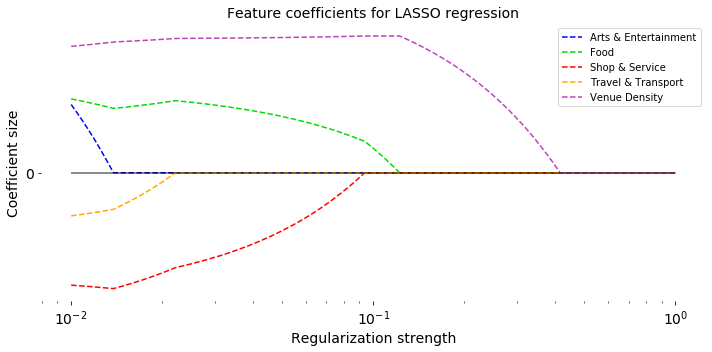

In [114]:
fig, ax = plt.subplots(figsize=(10,5))

for i in range(5):
    ax.plot(alpha_space, coefficients[:,i], c=colors[i], ls='dashed', linewidth=1.5)

ax.legend(X_dropped.columns)

ax.hlines(0, 1e-2, 1e0, color='black', zorder=20, alpha=0.6)

ax.set_title("Feature coefficients for LASSO regression", fontsize=14)

ax.set_xscale('log')
ax.set_xlabel("Regularization strength", fontsize=14)

ax.set_ylabel("Coefficient size", fontsize=14)
ax.set_yticks([0])

ax.tick_params(labelsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.show()

From this analysis, we conclude the same thing as from looking at the correlation between features and the rental price: Venue density is the most important feature, followed by the categories 'Food' and 'Shop & Service'. Indeed, we see that the R^2 values follow the same order.

In [115]:
x_dens = np.array(df['Venue Density']).reshape(-1,1)
x_food = np.array(df['Food']).reshape(-1,1)
x_shop = np.array(df['Shop & Service']).reshape(-1,1)

y = df['Rental_Price']

poly_model_dens = make_pipeline(PolynomialFeatures(3), LinearRegression())
poly_model_food = make_pipeline(PolynomialFeatures(3), LinearRegression())
poly_model_shop = make_pipeline(PolynomialFeatures(3), LinearRegression())

poly_model_dens.fit(x_dens, y)
poly_model_food.fit(x_food, y)
poly_model_shop.fit(x_shop, y)

print("The R^2-score of the model only using 'Venue Density', is {:3f}".format(poly_model_dens.score(x_dens, y)))
print("The R^2-score of the model only using 'Food', is {:3f}".format(poly_model_food.score(x_food, y)))
print("The R^2-score of the model only using 'Shop & Service', is {:3f}".format(poly_model_shop.score(x_shop, y)))

The R^2-score of the model only using 'Venue Density', is 0.666401
The R^2-score of the model only using 'Food', is 0.492850
The R^2-score of the model only using 'Shop & Service', is 0.374191


However, the correlation between 'Venue Density' and 'Food' is so large, that 'Shop & Service' provides 

In [116]:
x_food = df[['Food', 'Venue Density']]
x_shop = df[['Shop & Service', 'Venue Density']]

y = df['Rental_Price']

poly_model_food = make_pipeline(PolynomialFeatures(3), LinearRegression())
poly_model_shop = make_pipeline(PolynomialFeatures(3), LinearRegression())

poly_model_food.fit(x_food, y)
poly_model_shop.fit(x_shop, y)

print("The R^2-score of the model using 'Food' and 'Venue Density', is {:3f}".format(poly_model_food.score(x_food, y)))
print("The R^2-score of the model using 'Shop & Service' and 'Venue Density', is {:3f}".format(poly_model_shop.score(x_shop, y)))

The R^2-score of the model using 'Food' and 'Venue Density', is 0.700183
The R^2-score of the model using 'Shop & Service' and 'Venue Density', is 0.781302


# A simple attempt to build a better model

We are going to use a standard linear regression. We will split our data in a train and test set according to a 90%-10% split.

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

In [118]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

We calculate the mean absolute errors:

In [119]:
print("The MAE on the train set is given by {:.5f}".format(mean_absolute_error(y_train, model.predict(X_train))))
print("The MAE on the test set is given by {:.5f}".format(mean_absolute_error(y_test, model.predict(X_test))))

The MAE on the train set is given by 0.97908
The MAE on the test set is given by 1.65627


By plotting the predicted values versus the actual values in the test set, we see that the outliers skew the mean absolute error. Overall the model performs well.

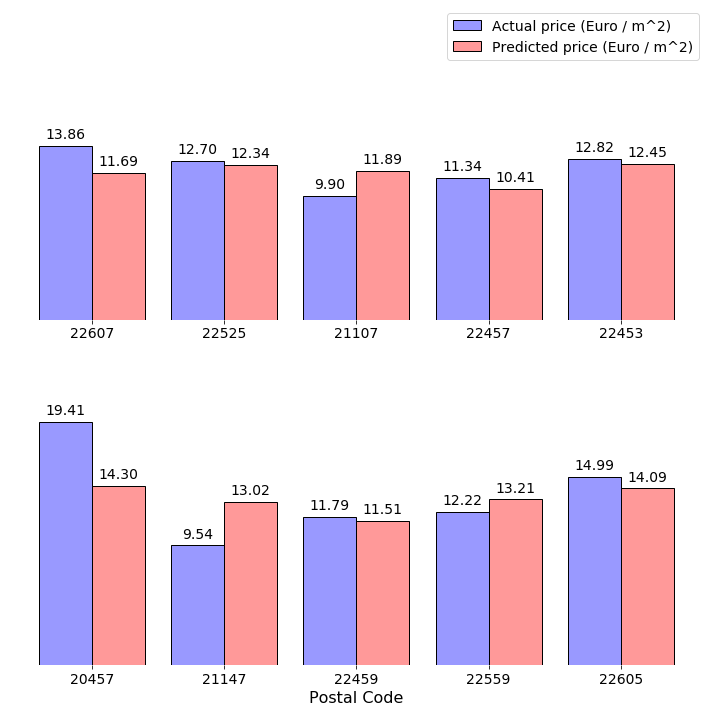

In [120]:
ind = np.arange(5)
width = 0.4

fig, axes = plt.subplots(2, 1, figsize=(10,10))

bar_test_top = axes[0].bar(ind - width/2, y_test[:5], width, color='#9999ff', edgecolor='black')
bar_pred_top = axes[0].bar(ind + width/2, model.predict(X_test[:5]), width, color='#ff9999', edgecolor='black')

bar_test_bot = axes[1].bar(ind - width/2, y_test[5:], width, color='#9999ff', edgecolor='black')
bar_pred_bot = axes[1].bar(ind + width/2, model.predict(X_test[5:]), width, color='#ff9999', edgecolor='black')

plt.setp(axes[:], xticks=ind, yticks=[], ylim=(0, 25))

axes[0].set_xticklabels(y_test[:5].index, fontsize=14)
axes[1].set_xticklabels(y_test[5:].index, fontsize=14)

axes[1].set_xlabel('Postal Code', fontsize=16)

axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['bottom'].set_visible(False)
axes[0].spines['left'].set_visible(False)

axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['bottom'].set_visible(False)
axes[1].spines['left'].set_visible(False)

axes[0].legend((bar_test_top, bar_pred_top), ("Actual price (Euro / m^2)", "Predicted price (Euro / m^2)"), fontsize=14)

for i in ind:
    axes[0].text(
        i - width/2, 
        y_test.iloc[i] + 0.6,
        "{:.2f}".format(y_test.iloc[i]),
        ha='center',
        fontsize=14
    )
    
    axes[0].text(
        i + width/2, 
        model.predict(X_test)[i] + 0.6,
        "{:.2f}".format(model.predict(X_test)[i]),
        ha='center',
        fontsize=14
    )
    
for i in ind:
    axes[1].text(
        i - width/2, 
        y_test.iloc[i+5] + 0.6,
        "{:.2f}".format(y_test.iloc[i+5]),
        ha='center',
        fontsize=14
    )
    
    axes[1].text(
        i + width/2, 
        model.predict(X_test)[i+5] + 0.6,
        "{:.2f}".format(model.predict(X_test)[i+5]),
        ha='center',
        fontsize=14
    )
    
plt.tight_layout()
    
plt.show()

The rental price of the postal code 20457 has been severely underestimated. Without this postal code, we find the following values for the mean absolute error:

In [121]:
# We find the iloc index corresponding to the postal code 20457

index = list(y.reset_index()[y.reset_index()['Postal_Code'] == 20457].index)

In [122]:
print("The MAE on this set is given by {:.5f}".format(mean_absolute_error(y_test[y_test.index != 20457], model.predict(X_test[X_test.index != 20457]))))

The MAE on this set is given by 1.27291


Let us take a look at this postal code in more detail.

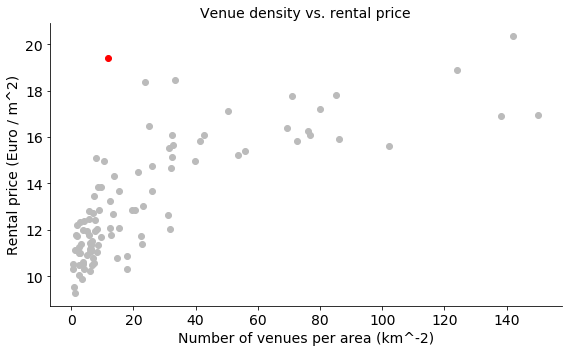

In [123]:
fig, ax = plt.subplots(figsize=(8,5))

ax.scatter(x[index], y.iloc[index], color='#ff0000', zorder=20)
ax.scatter(np.delete(x, index), y[~y.index.isin([20457])], color='#bbbbbb')

ax.set_xlabel("Number of venues per area (km^-2)", fontsize=14)
ax.set_ylabel("Rental price (Euro / m^2)", fontsize=14)
ax.set_title("Venue density vs. rental price", fontsize=14)

ax.tick_params(labelsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

We see that the venue density for postal code 20457 is very low compared to its rental price. A quick search shows that this postal code belongs to the harbour city. This is an expensive part of Hamburg, mainly for its great location near the Elbe. 

Nonetheless, a substantial portion of the area covered by this postal code is water or part of the harbour. The lack of venues in these parts lowers the overall venue density by a factor of ~5 to 10 compared to the living area. By removing the water and harbour areas, we may find a predicted price much closer to the actual rental price.

# What if we include more categories?

Previously we considered the main categories as defined by Foursquare to find a model determining the rental price. Are there also predictors we could take into account in other categories? If so, we expect these predictors to fall under the main categories 'Food' and 'Shop & Service' as these two are most strongly correlated to the rental price.

In [124]:
venue_df = pd.read_csv('Venues_Hamburg_Clean.csv')
rental_prices_df = pd.read_csv('Rental_Prices_Postal_Codes_Hamburg.csv')

In [125]:
venue_df.drop(columns=['Category_L1', 'Venue_Id', 'Latitude', 'Longitude', 'Name'], inplace=True)

In [126]:
venue_df_one_hot = pd.get_dummies(venue_df, prefix='', prefix_sep='', columns=['Category_L2', 'Category_L3', 'Category_L4'])

grouped_venue_df = venue_df_one_hot.groupby('Postal_Code').sum().div(venue_df.groupby('Postal_Code').size(), axis=0)

In [127]:
df = rental_prices_df.merge(grouped_venue_df, on='Postal_Code')

In [128]:
df = df.set_index('Postal_Code').drop(columns=['None'])

In [129]:
# We drop all categories which occur in less than 50 postal codes. We do this to ensure our predictions are general enough.

cols = df.columns

for col in cols:
    if len(df[df[col] != 0]) < 50:
        df.drop(columns=col, inplace=True)

In [130]:
# We only consider those options which correlate a reasonable amount with the rental price.

df.corr(method='kendall')['Rental_Price'][abs(df.corr(method='kendall')['Rental_Price']) > 0.3]

Rental_Price          1.000000
Asian Restaurant      0.326602
Bar                   0.382990
Bus Stop             -0.371905
Café                  0.390665
Food & Drink Shop    -0.409558
Italian Restaurant    0.384621
Supermarket          -0.472554
Name: Rental_Price, dtype: float64

Let us play around with two of these categories a bit: 'Supermarket' and 'Café'. The former falls in the category 'Food & Drink Shop' which in turn belongs to the main category 'Shop & Service'. The latter belongs to the main category 'Food'.

We will now split the rental prices in two bins: Low prices and high prices with cutoff 15 Euros / m^2. We are going to see if it is possible to predict whether a postal code belongs to the low or high priced category using logistic regression and only these two categories.

In [131]:
df['Rental_Bins'] = pd.cut(np.array(df['Rental_Price']).reshape(-1), bins=[0, 15, 30], labels=[0, 1])

In [132]:
X = df[['Supermarket', 'Café']]
y = df['Rental_Bins']

In [133]:
model = LogisticRegression(class_weight='balanced')
model.fit(X, y)

accuracy = (model.predict(X) == y).mean()

print("Logistic regression has an accuracy of {:.0f}% on the total set".format(100*accuracy))

Logistic regression has an accuracy of 83% on the total set


We see that we obtain a reasonably high accuracy. However, it should be noted that the logarithmic loss or the entropy is also very high. This is the result of a number of outliers. In principle, we may consider improving our logistic regression by including additional categories.

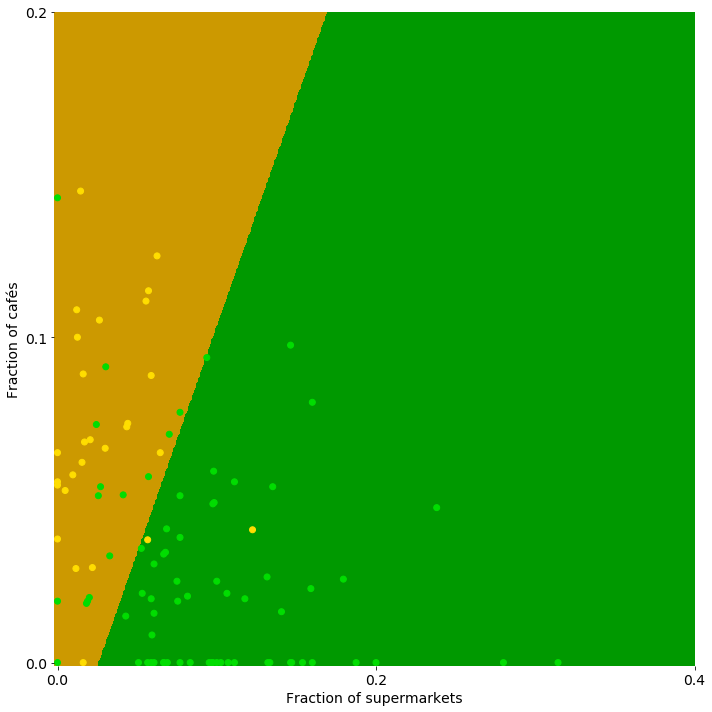

In [134]:
step = 5e-4
x1_fit, x2_fit = np.meshgrid(np.arange(-0.5, 0.45, step), np.arange(-0.5, 0.25, step))
y_pred = model.predict(np.c_[x1_fit.reshape(-1), x2_fit.reshape(-1)]).reshape(x1_fit.shape)

cmap_mesh = c.ListedColormap(['#009900', '#cc9900'])
cmap_scatter = c.ListedColormap(['#00dd00', '#ffdd00'])

fig, ax = plt.subplots(figsize=(10,10))

ax.pcolormesh(x1_fit, x2_fit, y_pred, cmap=cmap_mesh)
ax.scatter(X['Supermarket'], X['Café'], c=y, cmap=cmap_scatter)

ax.set_xlabel("Fraction of supermarkets", fontsize=14)
ax.set_ylabel("Fraction of cafés", fontsize=14)
              
ax.tick_params(labelsize=14)

ax.set_xlim(-2e-3, 0.4)
ax.set_ylim(-1e-3, 0.2)

ax.set_xticks([0, 0.2, 0.4])
ax.set_yticks([0, 0.1, 0.2])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.show()